# Neural Network with Backpropagation from Scratch

The Backpropagation algorithm is a **supervised learning** method for **multilayer feed-forward networks** from the field of Artificial Neural Networks. It can be used for both classification and regression problems

This algorithm can be broken into following steps:
* Initialize Network
* Forward Propagate
* Back Propagate Error
* Train Network
* Predict

## Creating Fake Data

In [1]:
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_features=3, n_redundant=0, n_samples=100, n_classes=2, random_state=101)

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [5]:
import matplotlib.pyplot as plt

In [6]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

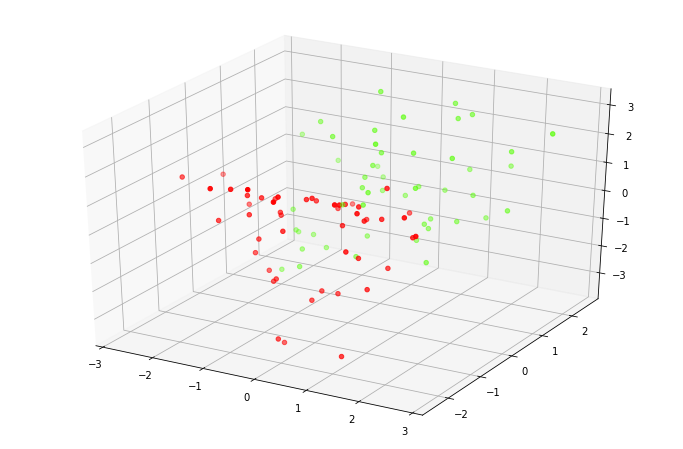

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2], c=y, cmap="prism")
plt.show()

## Initialize Network

Each neuron has a set of weights that need to be maintained. One weight for each input connection and an additional weight for the bias.

A network is organized into layers. The input layer is really just a row from our training dataset. The first real layer is the hidden layer. This is followed by the output layer that has one neuron for each class value.

It is good practice to initialize the network weights to small random numbers. In this case, will we use random numbers in the range of 0 to 1.

For Simplicity we will use only one hidden layer

In [17]:
class Neuron:
    def __init__(self, weights):
        self.weights = weights
        self.output = None
        self.delta = None

In [9]:
from random import seed, random

In [10]:
def initialize_network(n_input, n_hidden, n_output):
    seed(101)
    network = []
    network.append([Neuron([random() for _ in range(n_input+1)]) for _ in range(n_hidden)])
    network.append([Neuron([random() for _ in range(n_hidden+1)]) for _ in range(n_output)])
    return network

In [11]:
# Visualize the initialization
network = initialize_network(2,1,2)
for i in range(len(network)):
    print("Layer ",i+1)
    for neuron in network[i]:
        print(neuron.weights)

Layer  1
[0.5811521325045647, 0.1947544955341367, 0.9652511070611112]
Layer  2
[0.9239764016767943, 0.46713867819697397]
[0.6634706445300605, 0.21452296973796803]


## Forward Propagate
Forward Propagation refers to propagating an input signal through each layer until the output layer outputs its values. This can be broken down into three parts:
* Neuron Activation
* Neuron Transfer
* Forward Propagation

### Neuron Activation
The first step is to calculate the activation of one neuron given an input.
#### $activation = \sum\limits_{i=1}^n(weight_i\times input_i) + bias$

In [12]:
# We have taken the last column in each weight array as the bias
def activate(neuron, inputs):
    weights = neuron.weights
    activation = weights[-1] # Assigned the bias term to activation
    for i in range(len(weights)-1):
        activation += weights[i]*inputs[i]
    return activation

### Neuron Transfer
Once a neuron is activated, we need to transfer the activation to see what the neuron output actually is.

Different **Activation function** can be used for transfer. We are using **Sigmoid function**

### $output = \frac{1}{1+e^{-activation}}$

In [13]:
from math import exp
def transfer(activation):
    return 1/(1+exp(-activation))

### Forward Propagation
Here we work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer.

In [14]:
def forward_propagate(network, inputs):
    for layer in network:
        new_inputs=[]
        for neuron in layer:
            activation = activate(neuron, inputs)
            output = transfer(activation)
            neuron.output = output
            new_inputs.append(output)
        inputs = new_inputs
    return inputs

In [15]:
# Testing Forward Propagate
network = initialize_network(3,1,2)
forward_propagate(network, X_train[0])

[0.736872988764265, 0.5962622401129927]

## Back Propagate Error
Error is calculated between the expected outputs and the outputs forward propagated from the network. These errors are then propagated backward through the network from the output layer to the hidden layer, assigning blame for the error and updating weights as they go.

This part is broken down into two sections:
* Transfer Derivative
* Error Backpropagation

### Transfer Derivative
Calculating the derivative of our Activation function i.e. Sigmoid function in our case.
### $For \space y = \frac{1}{1+e^{-x}}$
### $\frac{dy}{dx} = y\times (1-y)$

In [16]:
def transfer_derivative(output):
    return output*(1-output)

### Error Backpropagation
The first step is to calculate the error for each output neuron, this will give us our error signal (input) to propagate backwards through the network.
#### $error = (y-\hat y) \times \frac{d\hat y}{dx}$ where :
* y is the expected output
* $\hat y$ is the output by the neuron

This error calculation is used for neurons in the output layer. In the hidden layer, things are a little more complicated.

The error signal for a neuron in the hidden layer is calculated as the weighted error of each neuron in the output layer. Think of the error traveling back along the weights of the output layer to the neurons in the hidden layer. The back-propagated error signal is accumulated and then used to determine the error for the neuron in the hidden layer, as follows:
#### $error = (weight_k \times error_j)\times \frac{d\hat y}{dx}$ where:
* $error_j$ is the error signal from the jth neuron in the output layer
* $weight_k$ is the weight that connects the kth neuron to the current neuron
* $\hat y$ is the output for the current neuron

In [18]:
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        # For Output layer
        if i == len(network)-1:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j]-neuron.output)
        # For Hidden layer
        else:
            for j in range(len(layer)):
                error = 0
                for neuron in network[i+1]:
                    error += neuron.weights[j]*neuron.delta
                errors.append(error)
        for j in range(len(layer)):
            neuron = layer[j]
            neuron.delta = errors[j]*transfer_derivative(neuron.output)

## Train Network
The network is trained using stochastic gradient descent.

This involves multiple iterations of exposing a training dataset to the network and for each row of data forward propagating the inputs, backpropagating the error and updating the network weights.

This part is broken down into two sections:
* Update Weights
* Train Network

### Update Weights
### $weight = weight + learning\space rate\times error\times input$

In [19]:
def update_weights(network, x, l_rate):
    for i in range(len(network)):
        inputs = x
        if i != 0:
            inputs = [neuron.output for neuron in network[i-1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                # Updating all weights
                neuron.weights[j] += l_rate*neuron.delta*inputs[j]
            # Updating Bias
            neuron.weights[-1] += l_rate*neuron.delta

### Train Network
This involves first looping for a fixed number of epochs and within each epoch updating the network for each row in the training dataset. Because updates are made for each training pattern, this type of learning is called **online learning**. If errors were accumulated across an epoch before updating the weights, this is called **batch learning or batch gradient descent**.

In [55]:
def fit(network, X, y, l_rate, n_epoch, n_output):
    errors = []
    for epoch in range(n_epoch):
        sum_error = 0
        for i in range(len(X)):
            outputs = forward_propagate(network, X[i])
            # One Hot Encoding
            expected = [0 for _ in range(n_output)]
            expected[y[i]] = 1
            # Sum Squared Error calculation
            sum_error += sum((expected[i]-outputs[i])**2 for i in range(n_output))
            backward_propagate_error(network,expected)
            update_weights(network, X[i], l_rate)
        errors.append(sum_error)
        print('epoch=%2d => error=%.3f' % (epoch+1, sum_error))
    return errors

In [56]:
n_inputs = len(X_train[0])
n_outputs = len(set(y_train))
n_epoch = 70
l_rate = 0.5
network = initialize_network(n_inputs, 2, n_outputs)
errors = fit(network, X_train, y_train, l_rate, n_epoch, n_outputs)
for i in range(len(network)):
    print("\nLayer:", i+1)
    for neuron in network[i]:
        print(neuron.weights)

epoch= 1 => error=36.358
epoch= 2 => error=31.605
epoch= 3 => error=24.063
epoch= 4 => error=16.268
epoch= 5 => error=12.052
epoch= 6 => error=10.084
epoch= 7 => error=9.054
epoch= 8 => error=8.442
epoch= 9 => error=8.043
epoch=10 => error=7.762
epoch=11 => error=7.552
epoch=12 => error=7.389
epoch=13 => error=7.258
epoch=14 => error=7.149
epoch=15 => error=7.057
epoch=16 => error=6.978
epoch=17 => error=6.908
epoch=18 => error=6.847
epoch=19 => error=6.793
epoch=20 => error=6.744
epoch=21 => error=6.700
epoch=22 => error=6.661
epoch=23 => error=6.624
epoch=24 => error=6.591
epoch=25 => error=6.561
epoch=26 => error=6.533
epoch=27 => error=6.507
epoch=28 => error=6.483
epoch=29 => error=6.461
epoch=30 => error=6.440
epoch=31 => error=6.420
epoch=32 => error=6.402
epoch=33 => error=6.384
epoch=34 => error=6.367
epoch=35 => error=6.351
epoch=36 => error=6.336
epoch=37 => error=6.321
epoch=38 => error=6.307
epoch=39 => error=6.293
epoch=40 => error=6.280
epoch=41 => error=6.268
epoch=42 =

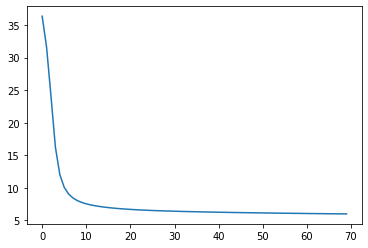

In [57]:
plt.plot(range(n_epoch), errors)

## Make Prediction

In [58]:
def predict_one(network, x):
    outputs = forward_propagate(network, x)
    return outputs.index(max(outputs))

In [59]:
pred = [predict_one(network, x) for x in X_test]

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[17  2]
 [ 0 11]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.92      0.95      0.93        30
weighted avg       0.94      0.93      0.93        30

